# German Credit dataset

## Contents

4. Build a baseline model
5. Prepare the data to better expose the underlying patterns to machine learning algorithm (incl feature engineering)
6. Explore many modesl; Select a model and train it
7. Fine-tune the model
8. Present your solution
9. Deploy, monitor and maintain your system



##### TODO

- keep the "networkx" splitting 
- make upsampling + transforming pipelines
- remember to incude "tenure/age" for certain models like LogisticRegression
- cros val score f2 (on the train set) - collect into a table
- cros val score auc (on the train set) - collect into a table
- look at the table with f2, AUC
- make confusion matreces (train on the Xtrain_dev, predict on the Xdev)
- make the "grey" plots (send the whole X_train into my function)
- finally select good classifiers
- HP for f2
- unite into a VC
- threshold optimize
- deploy



<br>

### Imports

In [1]:
# imports from Python Standard Library
import re, warnings

from itertools import combinations
from collections import Counter, OrderedDict
from statistics import mean

In [2]:
# Third party imports
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier


In [3]:
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

In [4]:
# sklearn imports
from sklearn.metrics import (accuracy_score, recall_score, precision_score, fbeta_score, roc_auc_score, classification_report)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import roc_auc_score
from sklearn.exceptions import NotFittedError
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import clone

# imbalanced-learn imports
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler


In [5]:
# Custom-made utilities
from src.helper_utilities import load_data
from src.modeling_utilities import Baseline, classification_scores, f2_scorer, auc_scorer
from src.plotting_utilities import plot_probabilities_distributions, plot_errors
from src.computing_utilities import optimize_threshold, error_sets_difference

In [6]:
# Settings
#warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

### Random Seed

In [7]:
random_state = None

### Load the data

In [8]:
# Get the (user-friendly) data for a baseline model
df = load_data(mode='analysis', format='dataframe')

# Save the "user friendly" dataframe for EDA as csv
df.to_csv("data/user_friendly_cats.csv", index=False)

# get the data from the saved csv due to the pd quirk with Ctegoricals
df = pd.read_csv("data/user_friendly_cats.csv")
df.head()


,tenure,amount,rate,residence,age,credits,maintenance,history,savings,employment,...,status,purpose,guarantor,installments,housing,telephone,foreign,sex,personal,label
0,6,1169,4,4,67,2,1,critical,no savings,"[7, inf)",...,overdrawn,television,none,none,ownership,yes,True,male,male single,0
1,48,5951,2,2,22,1,1,so far so good,"[0, 100)","[1, 4)",...,petty,television,none,none,ownership,none,True,female,female divorced/separated/married,1
2,12,2096,2,3,49,1,2,critical,"[0, 100)","[4, 7)",...,no account,education,none,none,ownership,none,True,male,male single,0
3,42,7882,2,4,45,1,2,so far so good,"[0, 100)","[4, 7)",...,overdrawn,furniture,guarantor,none,without payment,none,True,male,male single,0
4,24,4870,3,4,53,2,2,delay,"[0, 100)","[1, 4)",...,overdrawn,car,none,none,without payment,none,True,male,male single,1


# 4. Baseline model

This baseline model is based on a simple lookup table approach. You can view the code here:
[src/modeling_utilities.py](src/modeling_utilities.py)

In [9]:
# Train Test Split
X = df.copy()
y = X.pop('label')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)

In [10]:
# This baseline model is based on a simple lookup table approach
baseline = Baseline(best_features=['status', 'history', 'savings'], threshold=0.5)
baseline.fit(X_train, y_train)

Baseline(best_features=['status', 'history', 'savings'], threshold=0.5)

In [11]:
# Cross validation F2 score (on the whole dataset; with the default threshold of 0.5)
print("F2 =", cross_val_score(baseline, X_train, y_train, scoring=f2_scorer, cv=10).mean().round(2))

F2 = 0.46


In [12]:
# The default threshold of 0.5 givs us the following results on the test set:
y_pred = baseline.predict(X_test)
classification_scores(y_test, y_pred)

accuracy     0.74
precision    0.58
recall       0.50
f1           0.54
f2           0.51
dtype: float64

In [13]:
# AUC
y_score = baseline.predict_proba(X_test)
print("AUC =", roc_auc_score(y_test, y_score).round(2))

AUC = 0.74


In [14]:
# Hyperparameter grid search: the best model's threshold is 0.125 and has the F2 = 0.71
gs = GridSearchCV(baseline, {'threshold': np.linspace(0.05, 0.2, num=7)}, cv=10, scoring=f2_scorer).fit(X_train, y_train)
print("threshold =", round(gs.best_estimator_.threshold, 3), "\tF2 =", gs.best_score_.round(2))

threshold = 0.15 	F2 = 0.7


So, the goal is to beat the F2-score (and possibly the AUC)

<br>

# 5. Data Preprocessing

### Note how the features are ordered in the original dataset

In [15]:
# View the attribute names from the info document
path = 'data/german.doc'

with open(path, mode='r') as file:
    text = file.read()
    
pattern = r"Attr?ibute (?P<attr>\d{1,2}):.+?\n\s+(?P<name>.+?)\n"

print('\033[91m{}\033[0m'.format("Column index,"),  "original feature name and", '\033[92m{}\033[0m'.format("my short name"), end="\n\n")

# make a mapping from the "handy" name to the actual column index
column_index = dict()

for m in re.finditer(pattern, text):
    possible_names = [s for s in df.columns for pattern in (fr"\b{s}\b", fr"\b{s[:-1]}")
                      if re.search(pattern, m.groupdict()['name'], re.IGNORECASE)] or ['tenure']
    my_column_name = Counter(sorted(possible_names)).most_common(1)[0][0]
    print('\033[91m{}\033[0m'.format(int(m.groupdict()['attr'])-1), f"{m.groupdict()['name'].strip()}", '\033[92m({})\033[0m'.format(my_column_name))
    column_index[my_column_name] = int(m.groupdict()['attr'])-1


Column index, original feature name and my short name

0 Status of existing checking account (status)
1 Duration in month (tenure)
2 Credit history (history)
3 Purpose (purpose)
4 Credit amount (amount)
5 Savings account/bonds (savings)
6 Present employment since (employment)
7 Installment rate in percentage of disposable income (rate)
8 Personal status and sex (personal)
9 Other debtors / guarantors (guarantor)
10 Present residence since (residence)
11 Property (property)
12 Age in years (age)
13 Other installment plans (installments)
14 Housing (housing)
15 Number of existing credits at this bank (credits)
16 Job (job)
17 Number of people being liable to provide maintenance for (maintenance)
18 Telephone (telephone)
19 foreign worker (foreign)


### Load the original dataset

We'll opt for DataFrame as input into our model because we will want to determine feature data types dynamically with pandas' functionality.

In [16]:
# load the original dataset as df
X, y = load_data(mode='modeling', format='dataframe', introduce_nans=0.01, random_state=random_state)
X.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
995,A14,12.0,A32,A42,1736.0,A61,A74,3.0,A92,A101,4.0,A121,31.0,A143,A152,1.0,A172,1.0,A191,A201
996,A11,30.0,A32,A41,3857.0,A61,A73,4.0,A91,A101,4.0,A122,40.0,A143,A152,1.0,A174,1.0,A192,A201
997,A14,12.0,A32,A43,804.0,A61,A75,4.0,A93,A101,4.0,A123,38.0,A143,A152,1.0,A173,1.0,A191,A201
998,A11,45.0,A32,A43,1845.0,A61,A73,4.0,A93,A101,4.0,A124,23.0,A143,A153,1.0,A173,1.0,A192,A201
999,A12,45.0,A34,A41,4576.0,A62,A71,3.0,A93,A101,4.0,A123,27.0,A143,A152,1.0,A173,1.0,A191,A201


### Train Test Split

Because we do not want to touch the test set and we do not want any information leakage from the val set, we will split the dataset as follows.

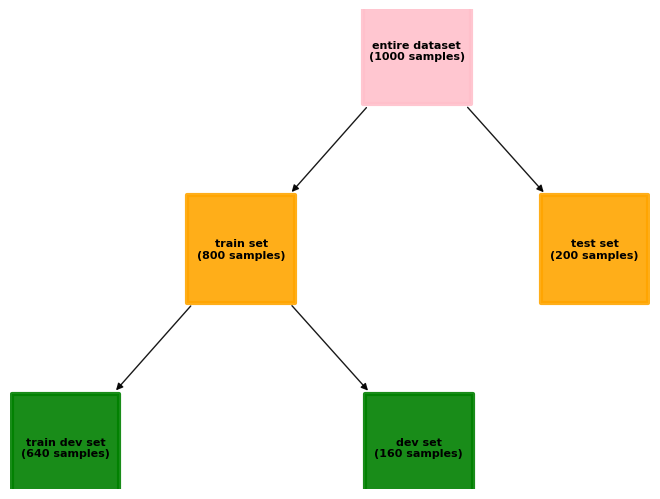

In [17]:
G = nx.DiGraph()  # with arrows

# Add nodes
G.add_node(0, label="entire dataset\n(1000 samples)", color='pink')
G.add_node(1, label="train set\n(800 samples)", color='orange')
G.add_node(2, label="test set\n(200 samples)", color='orange')
G.add_node(3, label="train dev set\n(640 samples)", color='green')
G.add_node(4, label="dev set\n(160 samples)", color='green')
#G.add_node(5, label="train set\n(512 samples)", color='lightblue')
#G.add_node(6, label="val set\n(128 samples)", color='lightblue')

# Add edges
G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(1, 3)
G.add_edge(1, 4)
#G.add_edge(3, 5)
#G.add_edge(3, 6)

pos = graphviz_layout(G, prog="dot")

labels = nx.get_node_attributes(G, "label")
colors = [G.nodes[node]['color'] for node in G.nodes()]

nx.draw(G, pos, with_labels=False, 
                arrows=True,
                node_shape="s",    # so^>v<dph8
                node_size=6000, 
                node_color=colors, 
                font_color='k',
                edge_color="k", 
                linewidths=3, 
                font_weight="bold", 
                alpha=0.9)

nx.draw_networkx_labels(G, pos, labels=labels, 
                                font_color="black", 
                                font_size=8, 
                                font_weight="bold")
plt.axis('off')  # Turn off axis
plt.savefig("assets/graph.png")  # Save as PNG

In [18]:
# the "orange" dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)

# the "green" dataset
X_train_dev, X_dev, y_train_dev, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

# X_... is a pd.DataFrame
X_test[:3]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
200,A14,9.0,A34,A46,936.0,A63,A75,4.0,A93,A101,2.0,A123,52.0,A143,A152,2.0,A173,1.0,A192,A201
416,A11,12.0,A32,A40,2579.0,NaN,A72,4.0,A93,A101,1.0,A121,33.0,A143,A152,1.0,A172,2.0,A191,A201
956,A13,30.0,A34,A43,3656.0,A65,A75,4.0,NaN,A101,4.0,A122,49.0,A142,A152,2.0,A172,1.0,A191,A201


# Shortlist promissing models

Quick and dirty models:
- logistic regression (L1) - remember to include the ratio feature
- naive bayes (Gaussian vs Categorical?)
- tree / random forest
- gradient boosting
- support vector machine
- neural network

metric: F2, AUC

In [19]:
# collect metrics 
collector = dict()

input_features = sorted(column_index.keys(), key=lambda k: column_index[k])

In [20]:
# Logistic Regression with L1 penalty

def make_ratio_pipline(imputer_strategy='median', log=False):
    steps = [
        ("imputer", SimpleImputer(strategy=imputer_strategy)),
        ("ratio", FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]], feature_names_out=lambda self, feature_names_in: ["ratio"])),
        ("log", FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out=lambda self, feature_names_in: ["log"])),
        ("scaler", StandardScaler()),
    ]

    if not log:
        del steps[-2]
    return Pipeline(steps)

# pipeline for the continuous numerical features
continuous_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),  # because the numerical features are right skewed
    ("log", FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out=lambda self, feature_names_in: [f"log_{name}" for name in feature_names_in])),   # comment out if necessary
    ("scaler", StandardScaler())
])

# pipeline for the discrete numerical features
discrete_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), StandardScaler())

# pipeline for the categorical features
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    )


# numerical features
continuous_features = [1, 4, 12]
discrete_features = [7, 10, 15, 17]
ratio_features = [1, 12]

steps = [
    ("oversampler", RandomOverSampler(random_state=random_state)),

    ("transformer",
        ColumnTransformer([
            ("ratio", make_ratio_pipline(imputer_strategy='median', log=True), ratio_features),
            ("continuous", continuous_pipeline, continuous_features),
            ("discrete", discrete_pipeline, discrete_features),
            ("categorical", categorical_pipeline, make_column_selector(dtype_include=['category', object]))
                    ], 
                remainder='drop'),
    ),
    
    ("classifier", LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=random_state))
]

lr = pl = ImbPipeline(steps)

cv = 10
collector[pl[-1].__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


In [21]:
# Naive Bayes

continuous_features = [1, 4, 12]
discrete_features = [7, 10, 15, 17]
categorical_features = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]
ratio_features = [1, 12]   # optional

# Gaussian NB
continuous_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),  # because the numerical features are right skewed
    ("log", FunctionTransformer(np.log, feature_names_out=lambda self, feature_names_in: [f"log_{name}" for name in feature_names_in])),   # comment out if necessary
    ("scaler", StandardScaler())
])

pl_num = make_pipeline(
    ColumnTransformer([
        ("num", continuous_pipeline, continuous_features),
        ("ratio", make_ratio_pipline(imputer_strategy='median', log=True), ratio_features)
                        ], remainder='drop'), 
    GaussianNB()
    )


# Categorical NB
pl = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

pl_cat = nb = make_pipeline(
    ColumnTransformer([("cat", pl, discrete_features + categorical_features)], remainder='drop'), 
    CategoricalNB()
    )

# Ensemble NB
nb = pl = vc = VotingClassifier(estimators=[("num", pl_num), ("cat", pl_cat)], voting='soft', weights=(0.01, 0.99))

cv = 10
collector[pl.__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


# adjust the balance
print(
cross_val_score(pl_num, X_train, y_train, scoring=f2_scorer, cv=cv).mean(),
cross_val_score(pl_cat, X_train, y_train, scoring=f2_scorer, cv=cv).mean(),
cross_val_score(vc, X_train, y_train, scoring=f2_scorer, cv=cv).mean()
)


0.32879363162332165 0.47974111395401675 0.47974111395401675


In [22]:
# Decision Tree 

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')
    )

steps = [
    ("oversampler", RandomOverSampler(random_state=random_state)),

    ("transformer",
        ColumnTransformer([
            ("num", SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number)),
            ("cat", cat_pipeline, make_column_selector(dtype_include=['category', object]))
                    ],
                remainder='passthrough'),
    ),

    ("classifier", DecisionTreeClassifier(min_samples_leaf=3, random_state=random_state))
]


dt = pl = ImbPipeline(steps)

cv = 10
collector[pl[-1].__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


In [23]:
# Random Forest

rf = pl = clone(dt)
pl.steps[-1] = ("classifier", RandomForestClassifier(n_estimators=100))

cv = 5
collector[pl[-1].__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


In [24]:
# Gradient Boosting

cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

steps = [
    ("oversampler", RandomOverSampler(random_state=random_state)),

    ("transformer",
        ColumnTransformer([
            ("num", SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number)),
            ("cat", cat_pipeline, make_column_selector(dtype_include=['category', object]))
                    ],
                remainder='passthrough'),
    ),

    ("classifier", LGBMClassifier(objective='binary', random_state=random_state))
]

# Fit, cross-validate
gb = pl = ImbPipeline(steps)

cv = 10
collector[pl[-1].__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


[LightGBM] [Info] Number of positive: 501, number of negative: 501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 402
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 502, number of negative: 502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 1004, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[Light

In [25]:
# SVC

num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')
    )

steps = [
    ("oversampler", RandomOverSampler(random_state=random_state)),

    ("transformer",
        ColumnTransformer([
            ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
            ("cat", cat_pipeline, make_column_selector(dtype_include=['category', object]))
                    ],
                remainder='passthrough'),
    ),

    ("classifier", SVC(probability=True, random_state=random_state))
]


sv = pl = ImbPipeline(steps)

cv = 10
collector[pl[-1].__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}

In [26]:
# ANN

def make_ratio_pipline(imputer_strategy='median', log=False):
    steps = [
        ("imputer", SimpleImputer(strategy=imputer_strategy)),
        ("ratio", FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]], feature_names_out=lambda self, feature_names_in: ["ratio"])),
        ("log", FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out=lambda self, feature_names_in: ["log"])),
        ("scaler", StandardScaler()),
    ]

    if not log:
        del steps[-2]
    return Pipeline(steps)

# pipeline for the continuous numerical features
continuous_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),  # because the numerical features are right skewed
    ("log", FunctionTransformer(np.log)),   # comment out if necessary
    ("scaler", StandardScaler())
])

# pipeline for the discrete numerical features
discrete_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), StandardScaler())

# pipeline for the categorical features
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    )


# numerical features
continuous_features = [1, 4, 12]
discrete_features = [7, 10, 15, 17]
ratio_features = [1, 12]

steps = [
    ("oversampler", RandomOverSampler(random_state=random_state)),

    ("transformer",
        ColumnTransformer([
            ("ratio", make_ratio_pipline(imputer_strategy='median', log=True), ratio_features),
            ("continuous", continuous_pipeline, continuous_features),
            ("discrete", discrete_pipeline, discrete_features),
            ("categorical", categorical_pipeline, make_column_selector(dtype_include=['category', object]))
                    ], 
                remainder='passthrough'),
    ),
    
    ("classifier", MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=300, random_state=random_state))
]

nn = pl = ImbPipeline(steps)

cv = 10
collector[pl[-1].__class__.__name__] = {
    "F2":  (temp := cross_val_score(pl, X_train, y_train, scoring=f2_scorer, cv=cv)).mean(),
    "sd(F2)": temp.std(),
    "AUC": cross_val_score(pl, X_train, y_train, scoring='roc_auc', cv=cv).mean(),
    "balanced accuracy": cross_val_score(pl, X_train, y_train, scoring='balanced_accuracy', cv=cv).mean(),
    "F1": cross_val_score(pl, X_train, y_train, scoring='f1', cv=cv).mean(),
}


/home/ubuntu/Repos/portfolio-project-classification-for-german-credit-dataset/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [27]:
pd.DataFrame(collector).T.sort_values('F2', ascending=False).round(2)

,F2,sd(F2),AUC,balanced accuracy,F1
LogisticRegression,0.65,0.06,0.77,0.71,0.59
SVC,0.62,0.07,0.78,0.71,0.58
LGBMClassifier,0.53,0.14,0.76,0.68,0.52
RandomForestClassifier,0.52,0.03,0.79,0.69,0.54
MLPClassifier,0.50,0.10,0.74,0.66,0.54
DecisionTreeClassifier,0.48,0.09,0.64,0.62,0.44
VotingClassifier,0.48,0.09,0.77,0.65,0.50


Based on the table above we will keep:
- LogisticRegression
- SVC
- LGBMClassifier
- MLPClassifier (because it identifies the samples the others miss - see the plot belo)
- RandomForestClassifier (maybe)


TODO:
Now, check the error set differences

- concidr useg smote


### Analyze feature importance

In [28]:
# Feature importances according to the logistic regression model
lr.fit(X_train, y_train)
sr = pd.Series(lr[-1].coef_.ravel(), index=lr[-2].get_feature_names_out(input_features=input_features)).sort_values(key=abs, ascending=False)
print("top most important features in the logistic model:")
sr.head(25)

top most important features in the logistic model:


categorical__purpose_A41         -1.886802
categorical__foreign_A202        -1.827831
categorical__status_A14          -1.606747
categorical__history_A34         -1.052242
categorical__savings_A64         -1.030177
categorical__purpose_A43         -0.939510
categorical__purpose_A49         -0.788920
categorical__property_A124        0.773941
categorical__job_A174             0.743115
categorical__purpose_A42         -0.736771
categorical__installments_A143   -0.710410
categorical__purpose_A48         -0.652623
categorical__savings_A65         -0.598759
categorical__purpose_A410        -0.467628
categorical__employment_A72       0.461461
categorical__status_A13          -0.455290
ratio__log                        0.448053
categorical__housing_A153        -0.401231
categorical__telephone_A192      -0.371455
categorical__employment_A74      -0.366150
categorical__status_A12          -0.330204
categorical__personal_A93        -0.329875
categorical__history_A31          0.324902
categorical

In [29]:
print("least important features in the logistic model:")
sr.tail(10)

least important features in the logistic model:


categorical__property_A122        0.065028
categorical__personal_A92        -0.026475
categorical__savings_A63         -0.016857
categorical__purpose_A46          0.007496
categorical__history_A33         -0.005418
discrete__maintenance             0.004817
categorical__job_A172             0.000000
continuous__log_tenure            0.000000
categorical__purpose_A45          0.000000
categorical__installments_A142    0.000000
dtype: float64

In [30]:
# Feature importances according to the tree model
dt.fit(X_train, y_train)
sr = pd.Series(dt[-1].feature_importances_, index=dt[-2].get_feature_names_out(input_features=input_features)).sort_values(ascending=False)
print("top most important features in the tree model:")
sr.head(10)

top most important features in the tree model:


cat__status_A14           0.150870
num__amount               0.130195
num__tenure               0.116413
num__age                  0.106989
num__residence            0.062673
num__maintenance          0.030387
cat__status_A13           0.028333
cat__installments_A143    0.025600
cat__history_A32          0.023800
cat__purpose_A43          0.022744
dtype: float64

In [31]:
print("least important features in the tree model:")
sr.tail(10)

least important features in the tree model:


cat__savings_A62     0.0
cat__purpose_A49     0.0
cat__purpose_A48     0.0
cat__purpose_A45     0.0
cat__purpose_A44     0.0
cat__purpose_A410    0.0
cat__history_A30     0.0
cat__status_A12      0.0
num__credits         0.0
cat__foreign_A202    0.0
dtype: float64

In [32]:
# Feature importances according to the random forest model
rf.fit(X_train, y_train)
sr = pd.Series(rf[-1].feature_importances_, index=rf[-2].get_feature_names_out(input_features=input_features)).sort_values(ascending=False)
print("top most important features in the tree model:")
sr.head(10)

top most important features in the tree model:


num__amount               0.094514
num__age                  0.083582
num__tenure               0.073838
cat__status_A14           0.055915
num__rate                 0.035620
num__residence            0.034363
cat__status_A11           0.030031
cat__history_A34          0.028951
cat__status_A12           0.021128
cat__installments_A143    0.020921
dtype: float64

In [33]:
print("least important features in the random forest model:")
sr.tail(10)

least important features in the random forest model:


cat__guarantor_A103    0.006297
cat__history_A30       0.006161
cat__purpose_A46       0.005979
cat__guarantor_A102    0.004169
cat__foreign_A202      0.003372
cat__purpose_A45       0.002999
cat__job_A171          0.002632
cat__purpose_A44       0.001879
cat__purpose_A410      0.001243
cat__purpose_A48       0.000767
dtype: float64

[LightGBM] [Info] Number of positive: 557, number of negative: 557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 1114, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 557, number of negative: 557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 1114, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


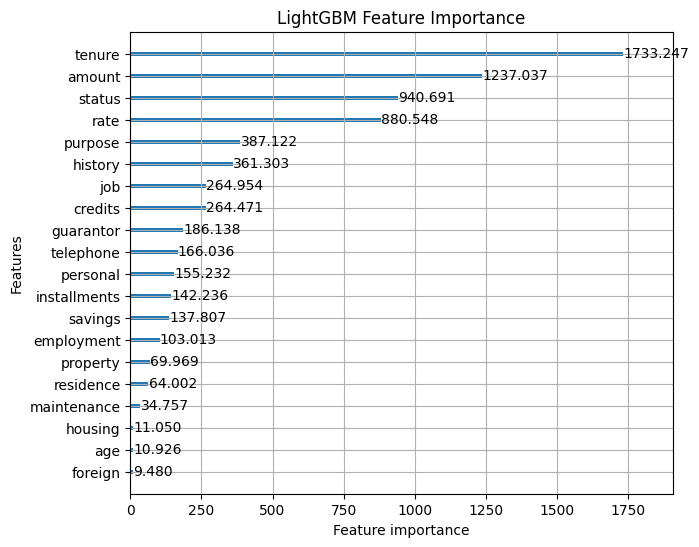

In [38]:
# Feature importances according to the gradient boosting model
gb.fit(X_train, y_train)
params = {f"{gb.steps[-1][0]}__categorical_feature": list(range(len(X_train.select_dtypes(include=np.number).columns), X_train.shape[1])),
          f"{gb.steps[-1][0]}__feature_name": list(gb[0].get_feature_names_out(input_features=input_features))}
gb.fit(X_train, y_train, **params)
lgb.plot_importance(gb.steps[-1][1], importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance");

### Determine the features which may be excluded from our model

According to our statistical tests earlier these features are useless: ['residence', 'job', 'credits', 'telephone', 'maintenance']

In [39]:
# sorted bad to worst
weak_features = ['residence', 'job', 'credits', 'telephone', 'maintenance']
features_to_keep = sorted(set(range(X.shape[1])) - set(column_index[k] for k in weak_features))

#input_features
#TODO

### View how certain the models are about their predictions

The following distributions of predicted probabilities show that the most certain models are the neural network, decision tree, followed by gradient boosting

[LightGBM] [Info] Number of positive: 441, number of negative: 441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 399
[LightGBM] [Info] Number of data points in the train set: 882, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


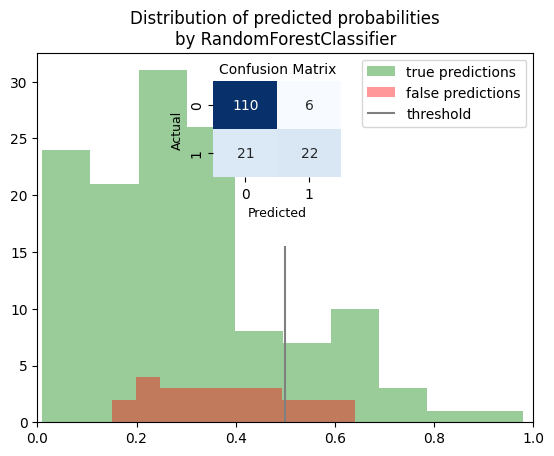

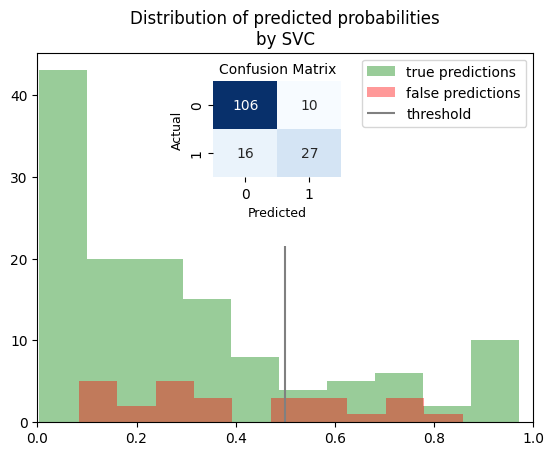

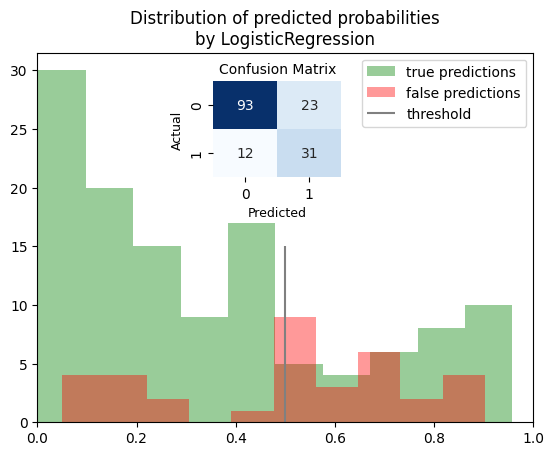

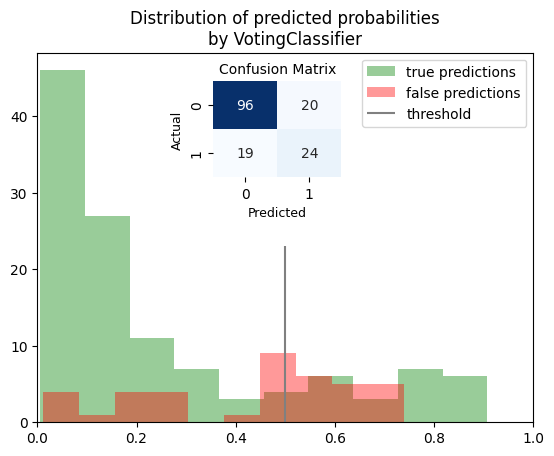

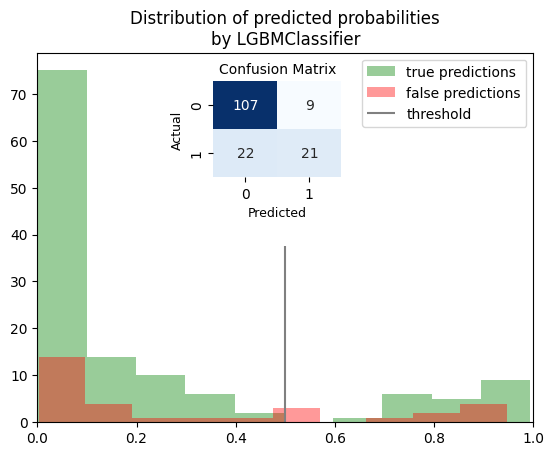

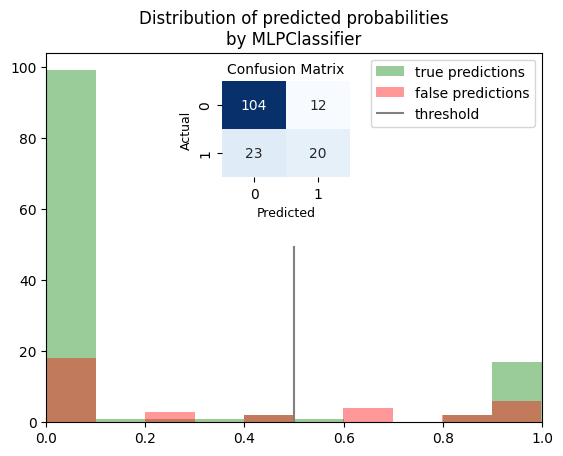

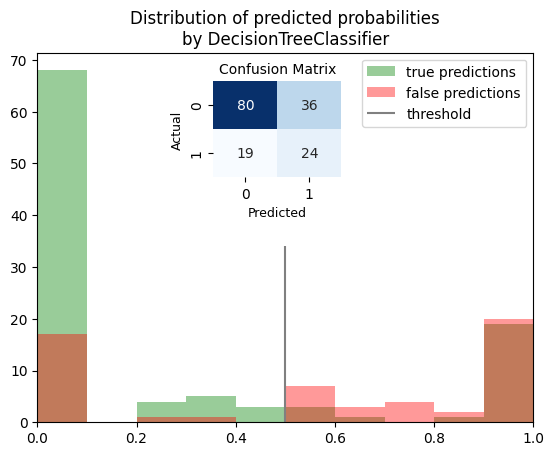

In [40]:
# View the distributions of predictions (ordered by the AUC)
mapping = dict(zip(('RandomForestClassifier', 'LogisticRegression', 'SVC', 'LGBMClassifier', 'VotingClassifier', 'MLPClassifier', 'DecisionTreeClassifier'),
        (rf, lr, sv, gb, vc, nn, dt)))

models = [mapping[k] for k in pd.DataFrame(collector).T.sort_values('AUC', ascending=False).index]

for model in models:
    fig = plt.figure()
    model.fit(X_train_dev, y_train_dev)
    plot_probabilities_distributions(model, X_dev, y_dev, n_bins=10, alpha=0.4)



### Have a look at the confusion matreces:

[LightGBM] [Info] Number of positive: 441, number of negative: 441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 882, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


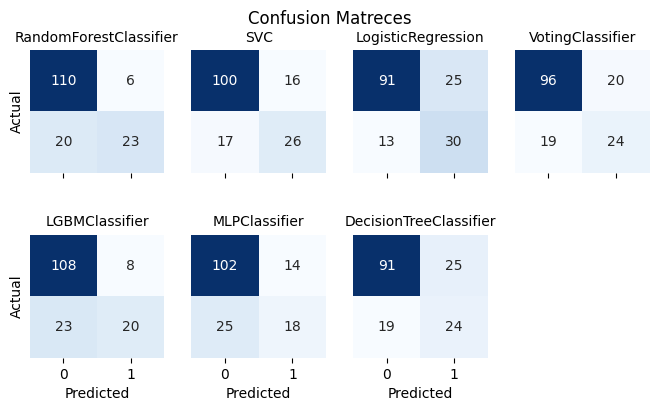

In [41]:
# Make confusion matreces (with cross validation using the train set)

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(8,4))
fig.suptitle("Confusion Matreces")

for i, (md, ax) in enumerate(zip(models, axes.ravel())):
    md.fit(X_train_dev, y_train_dev)
    cm = confusion_matrix(y_dev, md.predict(X_dev))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted') if i in (4,5,6) else ax.set_xticks([])
    ax.set_ylabel('Actual') if i in (0,4) else ax.set_yticks([])
    ax.set_title((md[-1] if hasattr(md, '__len__') else md).__class__.__name__, fontsize=10)
plt.delaxes(axes.ravel()[-1])
plt.subplots_adjust(hspace=0.5);

### Compare how different the FN the models make

In [42]:

collector = dict()
for pair in combinations(models, r=2):
    a,b = pair
    distance = error_sets_difference(y_dev, a.predict(X_dev), b.predict(X_dev),
                                     error_type='FN')
    #print(a[-1].__class__.__name__, "vs", b[-1].__class__.__name__, ":", round(distance,2))
    collector[(a[-1] if hasattr(a, '__len__') else a).__class__.__name__+ " vs " + (b[-1] if hasattr(b, '__len__') else b).__class__.__name__] = distance

pd.Series(collector).sort_values(ascending=False).round(2)

# the greater the distance the more diverse the errors the pair of classifiers make
# i.e. one of the two classifiesr with a low distance can be easily eliminated from th ensemble

VotingClassifier vs DecisionTreeClassifier          0.59
RandomForestClassifier vs LogisticRegression        0.57
LogisticRegression vs LGBMClassifier                0.56
VotingClassifier vs LGBMClassifier                  0.55
LogisticRegression vs DecisionTreeClassifier        0.55
SVC vs LGBMClassifier                               0.52
LGBMClassifier vs DecisionTreeClassifier            0.50
LogisticRegression vs MLPClassifier                 0.48
LogisticRegression vs VotingClassifier              0.48
SVC vs MLPClassifier                                0.44
RandomForestClassifier vs VotingClassifier          0.44
RandomForestClassifier vs DecisionTreeClassifier    0.44
SVC vs DecisionTreeClassifier                       0.43
SVC vs VotingClassifier                             0.43
SVC vs LogisticRegression                           0.42
LGBMClassifier vs MLPClassifier                     0.40
MLPClassifier vs DecisionTreeClassifier             0.37
VotingClassifier vs MLPClassifi

### Visualize how diverse the classifiers are in making errors

[LightGBM] [Info] Number of positive: 448, number of negative: 448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 398
[LightGBM] [Info] Number of data points in the train set: 896, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


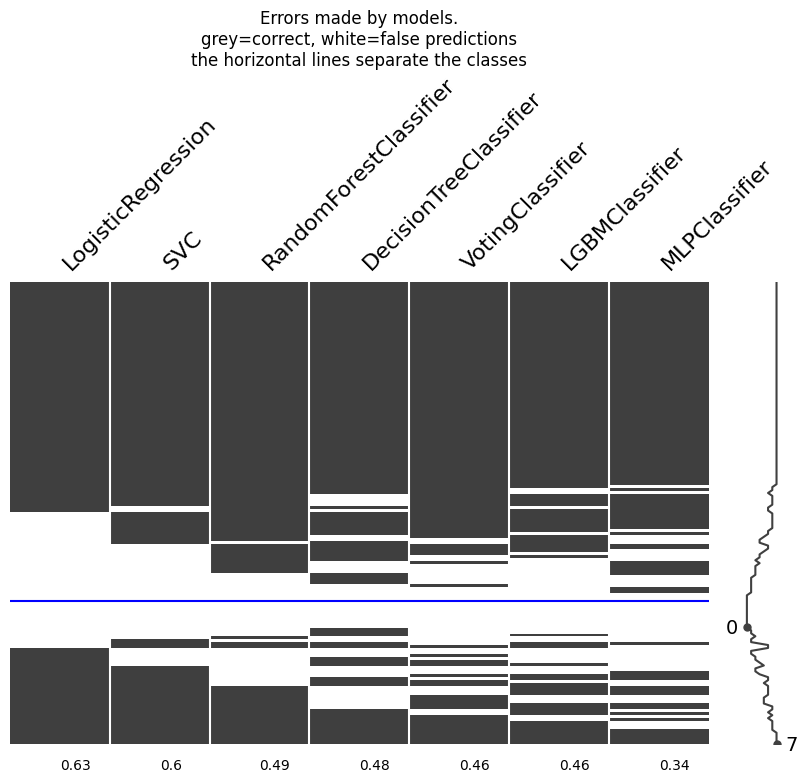

In [43]:
# my custom function to visualize errors
plot_errors(X_train, y_train, estimators=models, scorer=f2_scorer);

## TODO
- decide which feature(s) to exclude
- HP for F2 each clf
- make all possible combinjations of classifyer ensembels to get the best f2, after threshold optimization


# THE CHECKLIST

## Prepare the data
...

3. Encode, dummify categorical features. Maybe "numerize" categorical features with too many categories.

4. Feature engineering, where appropriate:
    - Discretize continuous features.
    - Decompose features (e.g., categorical, date/time, etc.)  SEX
    - Add promising transformations of features (e.g., log(x), sqrt(x), x^2, etc.).
    - Aggregate features into promising new features.

5. Feature scaling: standardize or normalize features.

## Short-list promising models  
Notes: 
- If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time (be aware that this penalizes complex models such as large neural nets or Random Forests).  
- Once again, try to automate these steps as much as possible.    

1. Train many quick and dirty models from different categories (e.g., linear, naive, Bayes, SVM, Random Forests, neural net, etc.) using standard parameters.  
2. Measure and compare their performance.  
    - For each model, use N-fold cross-validation and compute the mean and standard deviation of their performance. 
3. **Analyze the most significant variables for each algorithm.**
4. Analyze the types of errors the models make.  
    - What data would a human have used to avoid these errors?  
5. Have a quick round of feature selection and engineering.  
6. Have one or two more quick iterations of steps 1-5  
7. Short-list the top 3-5 most promising models, preferring models that **make different types of errors.**  






### Checklist:
https://github.com/leztien/Projects-Portfolio/blob/main/CHECKLITST.md




# Error Analysis

ChatGPT:

Performing an error analysis is an essential step in understanding a model's performance and the types of errors it makes. Here are steps to perform an error analysis:
1. Collect Predictions and True Labels

    Start with your model's predictions on a validation or test set.
    Collect the true labels corresponding to these predictions.

2. Confusion Matrix

    Construct a confusion matrix. This is particularly useful for classification tasks.
    For each class, the confusion matrix shows how many samples were correctly classified and how many were misclassified into other classes.
    This helps in understanding which classes are often confused with each other.

3. Calculate Metrics

    Calculate standard evaluation metrics like accuracy, precision, recall, and F1-score.
    These metrics provide an overall view of the model's performance but can be limited in understanding specific errors.

4. Analyze Misclassifications

    Look at individual samples that were misclassified.
    Examine the features, context, or patterns of these samples to identify commonalities.
    Pay attention to edge cases or samples with ambiguous labels.

5. Class-wise Analysis

    Perform a class-wise analysis:
        For each class, look at precision, recall, and F1-score.
        Identify which classes have low precision (false positive rate) or low recall (false negative rate).
        Determine if there's a class imbalance affecting the model's performance.

6. Visualizations

    Use visualizations to aid in understanding errors:
        Plotting actual vs. predicted values.
        ROC curves or precision-recall curves for binary classification.
        Distribution of scores or probabilities for correct and incorrect predictions.
        Feature importance or contribution to misclassifications.

7. Error Patterns

    Look for recurring error patterns:
        Are there specific types of inputs (e.g., images, sentences) that are consistently misclassified?
        Are there particular feature values or combinations that lead to errors?

8. Human Review

    In some cases, involve human reviewers to:
        Check misclassified samples to verify if the model's predictions are reasonable.
        Annotate the reason for misclassifications.
        Provide insights that might not be apparent from automated analysis.

9. Addressing Errors

    Based on the analysis, consider strategies to address specific errors:
        Collect more data for underrepresented classes.
        Engineer new features that might help the model.
        Adjust the model's hyperparameters.
        Use techniques like ensembling or different models for specific classes.




In [44]:


# THRESHOLD OPTIMIZATION

"""
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score
from functools import partial


# Get data
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and predict probabilities
clf = LogisticRegression().fit(X_train, y_train)
probs = clf.predict_proba(X_val)[:, 1]  # Probabilities of class 1

# Try all the thresholds
f2 = partial(fbeta_score, beta=2)
thresholds = np.linspace(0, 1, 100)
f2_scores = [f2(y_val, (probs > thresh).astype(int)) for thresh in thresholds]

best_threshold = thresholds[np.argmax(f2_scores)]
best_f2_score = max(f2_scores)
print("best threshold:", best_threshold)
print("best f2-Score:", best_f2_score)
""";